In [1]:
!pip install tensorflow opencv-python gradio jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 591.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 133.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5

# **Import Dependencies**

In [2]:
import pandas as pd
import numpy as np
import seaborn as ans
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
import gradio as gr

# **Preparing Dataset**

In [3]:
data = pd.read_csv('/content/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
x = data['comment_text']
y = data[data.columns[2:]].values

In [5]:
vectors = TextVectorization(max_tokens=200000, output_sequence_length=1800, output_mode='int')

In [6]:
vectors.adapt(x.values)
x_vector = vectors(x.values)

In [7]:
total_elements = len(x_vector)
train_size = int(0.7 * total_elements)
val_size = int(0.2 * total_elements)
test_size = total_elements - train_size - val_size


In [8]:
dataset = tf.data.Dataset.from_tensor_slices((x_vector, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [9]:
train = dataset.take(train_size // 16 + (1 if train_size % 16 > 0 else 0))
val = dataset.skip(train_size // 16 + (1 if train_size % 16 > 0 else 0)).take(val_size // 16 + (1 if val_size % 16 > 0 else 0))
test = dataset.skip((train_size + val_size) // 16 + (1 if (train_size + val_size) % 16 > 0 else 0)).take(test_size // 16 + (1 if test_size % 16 > 0 else 0))


# **Building a Model : Sequential**

In [10]:
model = Sequential()
model.add(Embedding(200000+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

In [11]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')


# **Evaluating the model performance**

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(train, epochs=1, validation_data=val)

6982/6982 ━━━━━━━━━━━━━━━━━━━━ 8432s 1s/step - loss: 0.0838 - val_loss: 0.0452


<Figure size 800x500 with 0 Axes>

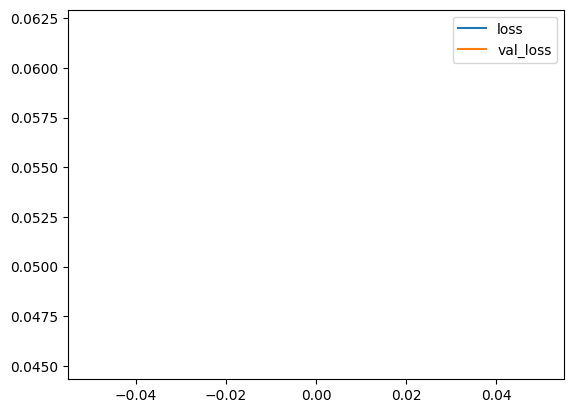

In [14]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [15]:
print(f"model accuracy : {model.evaluate(test)}")

998/998 ━━━━━━━━━━━━━━━━━━━━ 124s 122ms/step - loss: 0.0471
model accuracy : 0.04741879925131798


# **Testing the model**

In [19]:
input_text = vectors("I wish you would die")

In [21]:
input_text = np.expand_dims(input_text, axis=0)

In [22]:
ans = model.predict(input_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


In [23]:
(ans > 0.5).astype(int)

array([[1, 0, 0, 0, 0, 0]])

In [25]:
ans.shape

(1, 6)

In [26]:
toxicity_categories = data.columns[2:]

binary_predictions = (ans > 0.5).astype(int)[0]
print("Toxicity Predictions:")
for category, prediction in zip(toxicity_categories, binary_predictions):
    print(f"{category}: {prediction}")

Toxicity Predictions:
toxic: 1
severe_toxic: 0
obscene: 0
threat: 0
insult: 0
identity_hate: 0


# **Save the model**

In [27]:
model.save("Toxicity_Finder.h5")

# **Use the saved model for prediction**

In [33]:
input_text_x = vectors("hey Your asshole !!!")

In [34]:
models = tf.keras.models.load_model('Toxicity_Finder.h5')

In [35]:
answer = models.predict(np.expand_dims(input_text_x,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


In [36]:
answer

array([[0.98064476, 0.3573284 , 0.92725754, 0.09172097, 0.7879122 ,
        0.22451773]], dtype=float32)

In [37]:
toxicity_categories = data.columns[2:]

binary_predictions = (answer > 0.5).astype(int)[0]
print("Toxicity Predictions:")
for category, prediction in zip(toxicity_categories, binary_predictions):
    print(f"{category}: {prediction}")

Toxicity Predictions:
toxic: 1
severe_toxic: 0
obscene: 1
threat: 0
insult: 1
identity_hate: 0


# Predict your text -> Toxicity level

In [40]:
def score_comment(comment):
    vectorized_comment = vectors([comment])
    results = models.predict(vectorized_comment)
    text = ''
    for idx, col in enumerate(data.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [41]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')


In [42]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://046607f65b1c55850d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
